In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import re

sns.set()


def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

        
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

In [55]:
params = []
prefix = '/home/pecoffet/remoterobo/'
for path in sorted(glob.glob(f"{prefix}/logs/lions-maxtwo**-2019-06-19*/**/rep00/", recursive=True) 
                   + glob.glob(f"{prefix}/logs/lions-maxtwo*-2019-06-15*/**/rep00/", recursive=True)
                  + glob.glob(f"{prefix}/logs/lions-maxtwo*-2019-06-14*/**/rep00/", recursive=True)
                   + glob.glob(f"{prefix}/logs/lions-maxtwo*-2019-06-13*/**/rep00/", recursive=True)
                  + glob.glob(f"{prefix}/logs/lions-maxtwo**-2019-06-20*/**/rep00/", recursive=True)
                  + glob.glob(f"{prefix}/logs/lions-maxtwo**-2019-06-21*/**/rep00/", recursive=True)
                   + glob.glob(f"{prefix}/logs/lions-maxtwo**-2019-06-22*/**/rep00/", recursive=True)
                  ):
    print(path)
    try:
        logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    except Exception as e:
        print(e)
        continue
    print('*-*-*')
    params.append((path, readparams(glob.glob(path + 'properties*')[0]), logall.query('nbOnOpp == 2')['curCoopNoCoef'].mean()))



/home/pecoffet/remoterobo//logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b10-nocost-decay-1000-2019-06-14-1742/lion_big/o120/mt_true/run_01/rep00/
*-*-*
/home/pecoffet/remoterobo//logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b10-nocost-decay-1000-2019-06-14-1742/lion_big/o120/mt_true/run_02/rep00/
*-*-*
/home/pecoffet/remoterobo//logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b10-nocost-decay-500-2019-06-15-0459/lion_big/o120/mt_true/run_01/rep00/
*-*-*
/home/pecoffet/remoterobo//logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b10-nocost-decay-500-2019-06-15-0459/lion_big/o120/mt_true/run_02/rep00/
*-*-*
/home/pecoffet/remoterobo//logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b3-nocost-decay-1000-2019-06-14-1744/lion_big/o120/mt_true/run_01/rep00/
*-*-*
/home/pecoffet/remoterobo//logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b3-nocost-decay-1000-2019-06-14-1744/lion_big/o120/mt_true/run_02/rep00/
*-*-*
/home/pecoffet/remoterobo/

In [56]:
diffkeys = set()
missingkeys = set()
for i in range(len(params)):
    for key in params[i][1].keys():
        try:
            if any(params[j][1][key] != params[i][1][key] for j in range(0, len(params) - 1)):
                diffkeys.add(key)
        except KeyError:
            missingkeys.add(key)

In [57]:
excluded = ['gSeed', 'gLogFilename', 'path']
processed = []
for elem in params:
    param = elem[1]
    ess = param['meanA'] / 2
    so = param['meanA'] + param['b'] / 2
    outdict = {'coop': (elem[2] - ess) / (so - ess) , 'truecoop': elem[2]}
    for key in diffkeys:
        if key in excluded: continue
        outdict[key] = elem[1][key]
    processed.append(outdict)
    for key in missingkeys:
        if key in excluded: continue
        outdict[key] = elem[1].get(key, False)
df = pd.DataFrame(processed)
normalized_df=(df-df.mean())/df.std()

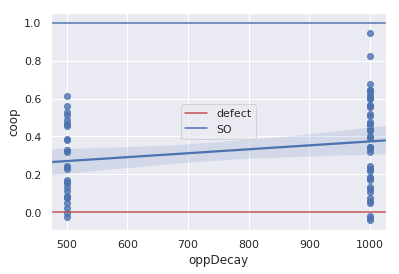

In [63]:
sns.regplot(x='oppDecay', y='coop', data=df)
plt.axhline(0, label='defect', c='r')
plt.axhline(1, label='SO', c='b')
plt.legend()

In [59]:
import statsmodels.formula.api as sm

In [60]:
normalized_df['nbRobots'] = normalized_df['gInitialNumberOfRobots']
normalized_df['tau'] = normalized_df['oppDecay']
normalized_df['coopVariability'] = normalized_df['fakeCoef']
normalized_df

,additiveVar,b,coop,costAsInput,fakeCoef,gInitialNumberOfRobots,gNbOfPhysicalObjects,gRandomSeed,logEveryXGen,oppDecay,truecoop,nbRobots,tau,coopVariability
0,-0.792165,-0.049369,-1.619922,NaN,-0.941832,-1.551966,-1.894340,1.499364,1.152336,0.792165,-1.214010,-1.551966,0.792165,-0.941832
1,-0.792165,-0.049369,-1.572591,NaN,-0.941832,-1.551966,-1.894340,1.499364,1.152336,0.792165,-1.180513,-1.551966,0.792165,-0.941832
2,-0.792165,-0.049369,-0.774363,NaN,-0.941832,-1.551966,-1.894340,0.077742,1.152336,-1.244831,-0.615592,-1.551966,-1.244831,-0.941832
3,-0.792165,-0.049369,-1.616188,NaN,-0.941832,-1.551966,-1.894340,0.077743,1.152336,-1.244831,-1.211367,-1.551966,-1.244831,-0.941832
4,-0.792165,-0.878759,-1.684634,NaN,-0.941832,-1.551966,-1.894340,-1.056873,1.152336,0.792165,-1.196964,-1.551966,0.792165,-0.941832
5,-0.792165,-0.878759,-1.023040,NaN,-0.941832,-1.551966,-1.894340,-1.056873,1.152336,0.792165,-0.947246,-1.551966,0.792165,-0.941832
6,-0.792165,-0.878759,-0.889640,NaN,-0.941832,-1.551966,-1.894340,-1.035753,1.152336,-1.244831,-0.896894,-1.551966,-1.244831,-0.941832
7,-0.792165,-0.878759,-1.513555,NaN,-0.941832,-1.551966,-1.894340,-1.035754,1.152336,-1.244831,-1.132391,-1.551966,-1.244831,-0.941832
8,-0.792165,-0.049369,-1.153302,NaN,-0.641780,-1.551966,-1.894340,0.949202,1.152336,-1.244831,-0.883774,-1.551966,-1.244831,-0.641780
9,-0.792165,-0.049369,-1.396719,NaN,-0.641780,-1.551966,-1.894340,0.949203,1.152336,-1.244831,-1.056044,-1.551966,-1.244831,-0.641780


In [61]:
result = sm.ols(formula="coop ~ nbRobots + b + tau + coopVariability + additiveVar", data=normalized_df).fit()

In [62]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coop   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     18.11
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           2.85e-11
Time:                        14:11:06   Log-Likelihood:                -70.561
No. Observations:                  72   AIC:                             153.1
Df Residuals:                      66   BIC:                             166.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.854e-16      0.079    3.6e-15      1.000      -0.158       0.158
nbRobots            0.6499      0.088      7.397      0.000       0.475       0.825
b                  -0.0682      0.100     -0.684      0.497      -0.267       0.131
tau                 0.1607      0.086      1.860      0.067      -0.012       0.333
coopVariability    -0.1459      0.137     -1.068      0.289      -0.419       0.127
additiveVar         0.2983      0.155      1.924      0.059      -0.011       0.608
==============================================================================
Omnibus:                        0.283   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.868   Jarque-Bera (JB):                0.140
Skew:                          -0.108   Prob(JB):                        0.932
Kurtosis:                       2.989   Cond. No.                         3.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
df.query('gInitialNumberOfRobots == 1000 and b == 10')

,additiveVar,b,coop,costAsInput,fakeCoef,gInitialNumberOfRobots,gNbOfPhysicalObjects,gRandomSeed,logEveryXGen,oppDecay,truecoop
14,False,10.0,0.598243,False,0.1,1000.0,720.0,-1.386321e+09,100.0,1000.0,6.986820
15,False,10.0,0.429166,False,0.1,1000.0,720.0,-1.386321e+09,100.0,1000.0,5.718742
16,False,10.0,0.616049,False,0.1,1000.0,720.0,-1.776713e+09,100.0,500.0,7.120371
17,False,10.0,0.326368,False,0.1,1000.0,720.0,-1.776713e+09,100.0,500.0,4.947763
22,False,10.0,0.517237,False,0.2,1000.0,720.0,-1.819918e+09,100.0,1000.0,6.379277
23,False,10.0,0.647662,False,0.2,1000.0,720.0,-1.819919e+09,100.0,1000.0,7.357466
28,True,10.0,0.491366,False,0.5,1000.0,720.0,1.861625e+09,50.0,1000.0,6.185248
29,True,10.0,0.629487,False,0.5,1000.0,720.0,1.861625e+09,50.0,1000.0,7.221150
32,True,10.0,0.507974,False,1.0,1000.0,720.0,1.872786e+09,50.0,1000.0,6.309807
33,True,10.0,0.563344,False,1.0,1000.0,720.0,1.872786e+09,50.0,1000.0,6.725079
